In [12]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

# runs the util notebook so that those functions are available
%run utils.ipynb

* Split data into test train split
* Do a baseline default settings SVM model with linear one against the rest
* Iterating through runs of SVM with different hyperparameters to find the best hyperparameters, using GridSearch. 
* Baseline with linear SVM, and *then explore options for nonlinear SVM. 
* Select the best model and justify
* Test accuracy of best model

In [13]:
from sklearn.model_selection import train_test_split

# data shuffled while loading in
X, y, features = load_standardized_beans()

# holding out a test set for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2) 

In [14]:
# Doing a baseline SVM, with the default parameters. Default C is 1.0
classifier = svm.SVC(kernel="linear")

# But let's do cross validation, and with Stratified K folds, to makes sure we have a good sense of the baseline. 
# I've put this into a function to make sure that we test these classifiers in a consistent manner. 

test_classifier(classifier, X_train, y_train)

Classifier type: SVC
Classifier paramaters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9263416728777735


Scikit Learn's documentation says that the One Versus One option for the decision_function_shape argument is deprecated, and that One Versus Rest is both recommended and the default. Doesn't seem to change the results much, so moving forward we will leave it with the default that the package recommends, the One Versus Rest. 

In [15]:
classifier = svm.SVC(kernel="linear", decision_function_shape='ovo')

test_classifier(classifier, X_train, y_train)

Classifier type: SVC
Classifier paramaters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9266168175259086


Just to verify our assumption, before we proceed forward, that the standardized data provides a benifit over the raw data:

In [18]:
%%cache

# Trying SVM classification with the non-standardized data

X, y, features = load_beans()

classifier = svm.SVC(kernel="linear")
test_classifier(classifier, X_train, y_train)

Classifier type: SVC
Classifier paramaters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Yes. It looks like the standardized data provides some accuracy benefit over the raw data. Maybe the biggest improvement is with computation time. Regardless, we will leave the raw data behind now, and only work with the standardized data. 

In [8]:
X, y, features = load_standardized_beans()


Now that we have established a baseline model accuracy of **92.6%** using a linear SVM model with scikit learn's defaults and a standardized dataset, we will proceed to tuning our hyperparameters and seeing if we can find a better model for predicting the dry bean varieties. 

In [5]:
#Discard this in final report

C_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy = []
for C in C_list :
    classifier = svm.SVC(kernel="linear", C=C)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(np.mean(y_test == y_pred))

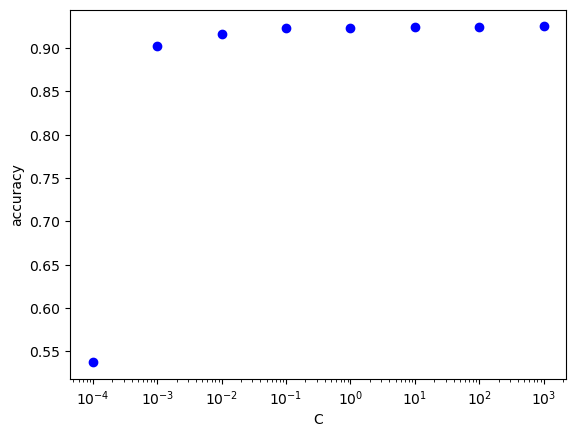

In [6]:
#Discard this in final report
plt.semilogx(C_list, accuracy, 'ob')
plt.xlabel('C')
plt.ylabel('accuracy');

In [7]:
#Discard this in final report

accuracy

[0.5373499877541024,
 0.9015429831006613,
 0.9164829782023022,
 0.9223610090619643,
 0.9233406808719079,
 0.9235855988243938,
 0.9245652706343375,
 0.9248101885868234]

## GridSearch

Parameter tuning

In [4]:
# broke up grid search by kernel types, as it was taking too long when combined. 
from sklearn.model_selection import GridSearchCV
gammas = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
Cs = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
# the following defines two grids - one for the linear kernel
# and a second grid for the Gaussian kernel
param_grid = [
  {'C': Cs,
   'kernel': ['linear']}
 ]

# instantiate a GridSearchCV object with SVM as the underlying classifier
# with the grid defined above
gridclassifier = GridSearchCV(svm.SVC(), param_grid, cv=stratcv )

gridclassifier.fit(X_train, y_train)

import pandas as pd

results = pd.DataFrame({
    'Parameters': gridclassifier.cv_results_['params'],
    'Mean Accuracy': gridclassifier.cv_results_['mean_test_score'],
    'Std Dev Accuracy': gridclassifier.cv_results_['std_test_score']
    })

results = results.sort_values(by='Mean Accuracy', ascending=False)
results.to_csv('gridsearch_results_linear.csv')


In [5]:
gammas = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
Cs = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
# the following defines two grids - one for the linear kernel
# and a second grid for the Gaussian kernel
param_grid = [
  {'C': Cs,
   'gamma': gammas,
   'kernel': ['rbf']}
 ]

# instantiate a GridSearchCV object with SVM as the underlying classifier
# with the grid defined above
gridclassifier = GridSearchCV(svm.SVC(), param_grid, cv=stratcv )

gridclassifier.fit(X_train, y_train)

import pandas as pd

results = pd.DataFrame({
    'Parameters': gridclassifier.cv_results_['params'],
    'Mean Accuracy': gridclassifier.cv_results_['mean_test_score'],
    'Std Dev Accuracy': gridclassifier.cv_results_['std_test_score']
    })

results = results.sort_values(by='Mean Accuracy', ascending=False)
results.to_csv('gridsearch_results_rbf.csv')

In [7]:
# This should be eliminated. It takes sooo long. Haven't gotten it to finish yet, and I've let it run for like 24 hours. 

gammas = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
Cs = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
# the following defines two grids - one for the linear kernel
# and a second grid for the Gaussian kernel
param_grid = [
  {'C': Cs,
   'gamma': gammas,
   'degree': [2],
   'kernel': ['poly']}
 ]

# instantiate a GridSearchCV object with SVM as the underlying classifier
# with the grid defined above
gridclassifier = GridSearchCV(svm.SVC(), param_grid, cv=stratcv )

gridclassifier.fit(X_train, y_train)
import pandas as pd

results = pd.DataFrame({
    'Parameters': gridclassifier.cv_results_['params'],
    'Mean Accuracy': gridclassifier.cv_results_['mean_test_score'],
    'Std Dev Accuracy': gridclassifier.cv_results_['std_test_score']
    })

results = results.sort_values(by='Mean Accuracy', ascending=False)
results.to_csv('gridsearch_results_poly.csv')

In [21]:
gridclassifier.best_estimator_

SVC(C=0.01, kernel='linear')

In [22]:
gridclassifier.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [23]:
gridclassifier.best_score_

0.92293004080137

In [25]:
classifier = svm.SVC(kernel="linear", C=.01)

test_classifier(classifier, X_train, y_train)

Classifier type: SVC
Classifier paramaters:  {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9229300138181216


## Feature Elimination
Below, I'm exploring whether is worth eliminating any features. 

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

selector = RFE(svm.SVC(kernel='linear'), step=0.1, 
               n_features_to_select=10)

pipeline = Pipeline(
    [('feature_selector', selector),
     ('classifier', svm.SVC(kernel='linear'))])
accuracy = cross_val_score(pipeline, X, y, cv=stratcv, scoring='accuracy')
np.mean(accuracy)



0.9188888406188553

In [23]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline, 
                          {'feature_selector__n_features_to_select' : 
                           np.arange(1, 17)})
accuracy = cross_val_score(grid_search, X, y, cv=stratcv, scoring='accuracy')
np.mean(accuracy)

0.926530334702913

In [24]:
grid_search.fit(X, y)
grid_search.best_params_

{'feature_selector__n_features_to_select': 15}

In [29]:
#trying to find which feature was eliminated in the best option:
print(grid_search.best_estimator_['feature_selector'].support_ )

[ True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True]


In [45]:
test_classifier(grid_search.best_estimator_, X, y)

Classifier type: Pipeline
Classifier paramaters:  {'memory': None, 'steps': [('feature_selector', RFE(estimator=SVC(kernel='linear'), n_features_to_select=15, step=0.1)), ('classifier', SVC(kernel='linear'))], 'verbose': False, 'feature_selector': RFE(estimator=SVC(kernel='linear'), n_features_to_select=15, step=0.1), 'classifier': SVC(kernel='linear'), 'feature_selector__estimator__C': 1.0, 'feature_selector__estimator__break_ties': False, 'feature_selector__estimator__cache_size': 200, 'feature_selector__estimator__class_weight': None, 'feature_selector__estimator__coef0': 0.0, 'feature_selector__estimator__decision_function_shape': 'ovr', 'feature_selector__estimator__degree': 3, 'feature_selector__estimator__gamma': 'scale', 'feature_selector__estimator__kernel': 'linear', 'feature_selector__estimator__max_iter': -1, 'feature_selector__estimator__probability': False, 'feature_selector__estimator__random_state': None, 'feature_selector__estimator__shrinking': True, 'feature_selector

In [31]:
X1 = X_train[:,:8]
X2 = X_train[:,9:]
X_train_less = np.hstack((X1,X2))
X_train_less.shape

(10888, 15)

In [41]:

classifier = svm.SVC(kernel="rbf", C=1000, gamma=.01)

test_classifier(classifier, X_train_less, y_train)

Classifier type: SVC
Classifier paramaters:  {'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9288200415648531


I don't see any compelling benefit to dropping any features right now. 

## BayesSearch

Below, I'm seeing if there is a way to tune the hyperparameters a little more. 

In [ ]:
from skopt import BayesSearchCV

bayesclass = BayesSearchCV(svm.SVC(kernel="rbf"), search_spaces={'C': (1.0, 3000.0), 'gamma': (.001, .1)}, n_iter=100)
bayesclass.fit(X, y)


In [66]:
# I haven't figured out why this is causing an error. Seems like from the documentation that BayesSearchCV does
# have a cv_results_ with these items stored in it.
#  https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
results = pd.DataFrame({
    'Parameters': bayesclass.cv_results_['params'],
    'Mean Accuracy': bayesclass.cv_results_['mean_test_score'],
    'Std Dev Accuracy': bayesclass.cv_results_['std_test_score']
    })
results = results.sort_values(by='Mean Accuracy', ascending=False)
results.to_csv('bayessearch_results_rbf.csv')

AttributeError: 'BayesSearchCV' object has no attribute 'results_'

In [60]:
bayesclass.best_params_

OrderedDict([('C', 762.3029249061822), ('gamma', 0.02841394910837692)])

In [61]:
classifier = svm.SVC(kernel="rbf", C=762.3029249061822, gamma=0.02841394910837692)

test_classifier(classifier, X_train_less, y_train)

Classifier type: SVC
Classifier paramaters:  {'C': 762.3029249061822, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.02841394910837692, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9286380318826971


## Heatmaps of parameter space

Looking at the results of the gridsearch and seeing if there seem to be areas of our parameter space that we are missing that might have good accuracy. 

In [70]:
import seaborn as sns
import ast

data = pd.read_csv('gridsearch_results_rbf.csv')
# dictionary wasn't loading correct
data['Parameters'] = data['Parameters'].apply(ast.literal_eval)

df = pd.DataFrame({
    'Mean Accuracy': data['Mean Accuracy'],
    'gamma': data['Parameters'].apply(lambda x: x['gamma']),
    'C': data['Parameters'].apply(lambda x: x['C'])
    })

heatdf = df.pivot('gamma', 'C', 'Mean Accuracy')


In [ ]:

plt.figure(figsize=(10, 8))
sns.heatmap(heatdf, annot=True, fmt=".3f")
plt.show()

It's sort of hard to see the gradient among the accuracies at the higher end, so I will filter out any rows where the accuracy is less than .9:

In [ ]:
df = df[df['Mean Accuracy'] > .9]
heatdf = df.pivot('gamma', 'C', 'Mean Accuracy')

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatdf, annot=True, fmt=".3f")
plt.show()

That's better. I think it's worth considering some higher C values, and also zooming in on the parameter space where we are getting the best accuracy. 

In [68]:
gammas = np.logspace(-6, 0, num=20, endpoint=True, base=10.0)
Cs = np.logspace(0, 4, num=20, endpoint=True, base=10.0)
# the following defines two grids - one for the linear kernel
# and a second grid for the Gaussian kernel
param_grid = [
  {'C': Cs,
   'gamma': gammas,
   'kernel': ['rbf']}
 ]

# instantiate a GridSearchCV object with SVM as the underlying classifier
# with the grid defined above
gridclassifier = GridSearchCV(svm.SVC(), param_grid, cv=stratcv )

gridclassifier.fit(X_train, y_train)

import pandas as pd

results = pd.DataFrame({
    'Parameters': gridclassifier.cv_results_['params'],
    'Mean Accuracy': gridclassifier.cv_results_['mean_test_score'],
    'Std Dev Accuracy': gridclassifier.cv_results_['std_test_score']
    })

results = results.sort_values(by='Mean Accuracy', ascending=False)
results.to_csv('gridsearch_results_rbf_zoom.csv')

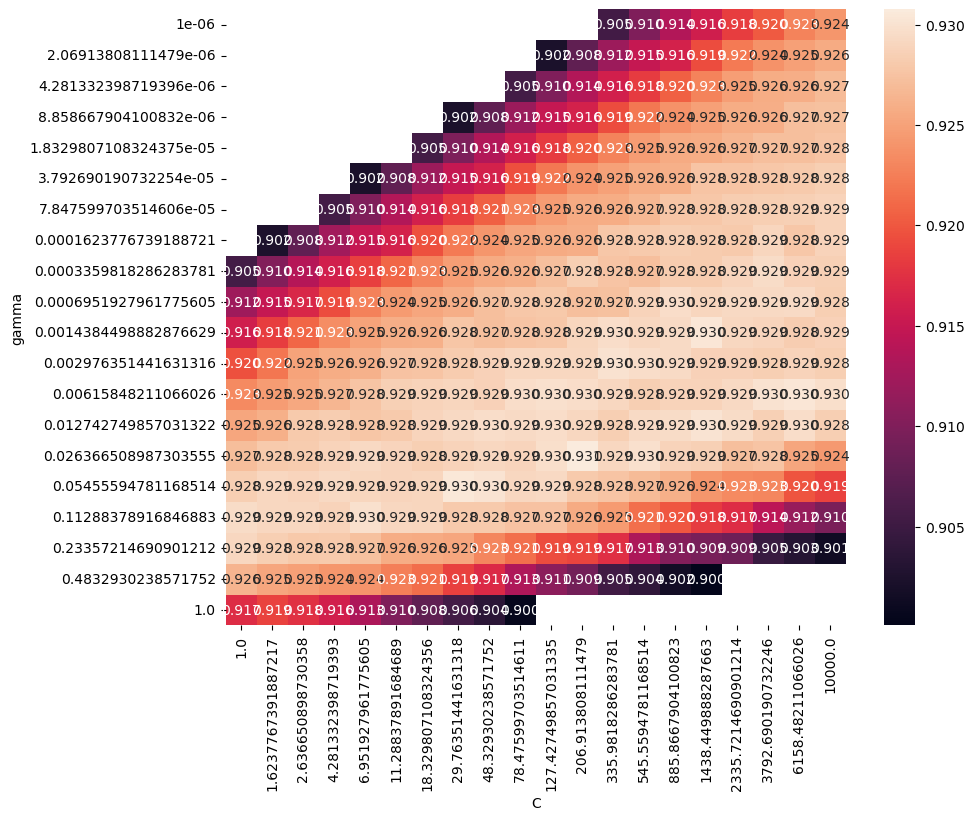

In [71]:
data = pd.read_csv('gridsearch_results_rbf_zoom.csv')
data['Parameters'] = data['Parameters'].apply(ast.literal_eval)

df = pd.DataFrame({
    'Mean Accuracy': data['Mean Accuracy'],
    'gamma': data['Parameters'].apply(lambda x: x['gamma']),
    'C': data['Parameters'].apply(lambda x: x['C'])
    })

df = df[df['Mean Accuracy'] > .9]
heatdf = df.pivot('gamma', 'C', 'Mean Accuracy')
plt.figure(figsize=(10, 8))
sns.heatmap(heatdf, annot=True, fmt=".3f")
plt.show()
